In [1]:
#import necessary libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from fim import arules
from operator import attrgetter
from fim import apriori
import datetime as dt
import squarify as sq

import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#import the dataset
df = pd.read_csv("/Users/georgekas/EDA_Project/E-Commerce-Analysis/data/Brazilian_E-Commerce_Cleaned.csv")
df.shape

(113390, 34)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113390 entries, 0 to 113389
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     113390 non-null  int64  
 1   order_id                       113390 non-null  object 
 2   customer_id                    113390 non-null  object 
 3   order_status                   113390 non-null  object 
 4   order_purchase_timestamp       113390 non-null  object 
 5   order_approved_at              113390 non-null  object 
 6   order_delivered_carrier_date   113390 non-null  object 
 7   order_delivered_customer_date  113390 non-null  object 
 8   order_estimated_delivery_date  113390 non-null  object 
 9   order_item_id                  113390 non-null  int64  
 10  product_id                     113390 non-null  object 
 11  seller_id                      113390 non-null  object 
 12  shipping_limit_date           

In [4]:
# Parse order_purchase_timestamp as datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

#### Monthly Sales Trend

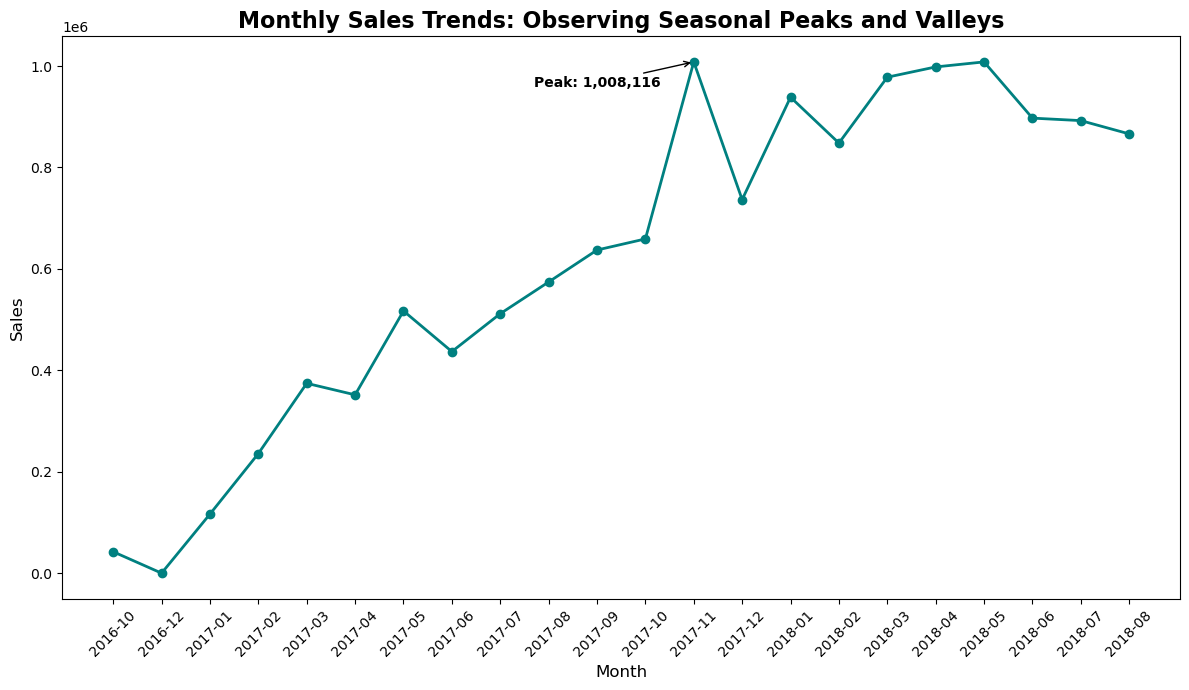

In [5]:
#Monthly Sales Trends
monthly_sales = df.groupby(df['order_purchase_timestamp'].dt.to_period('M'))['price'].sum()

# Plot with enhancements
plt.figure(figsize=(12, 7))
plt.plot(
    monthly_sales.index.astype(str), 
    monthly_sales.values, 
    marker='o', 
    color='teal', 
    linewidth=2, 
    markersize=6
)

# Titles and labels
plt.title("Monthly Sales Trends: Observing Seasonal Peaks and Valleys", fontsize=16, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Adding annotations for storytelling
peak_month = monthly_sales.idxmax()
peak_value = monthly_sales.max()
plt.annotate(
    f"Peak: {peak_value:,.0f}", 
    xy=(str(peak_month), peak_value), 
    xytext=(monthly_sales.index.get_loc(peak_month) - 2, peak_value * 0.95),  
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10,
    weight='bold',
    color='black',
    ha='center')

# Adjusting layout
plt.tight_layout()

# Display the plot
plt.show()

#### Top 10 Products by Sales

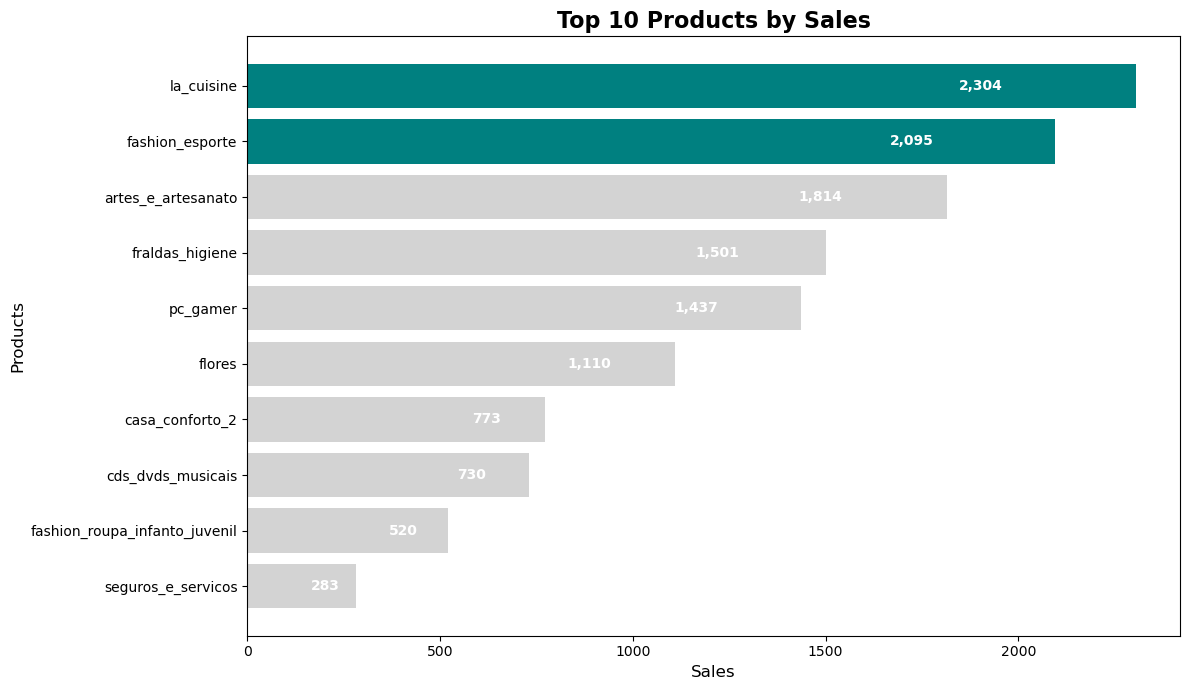

In [6]:
# Calculate top 10 products by sales
top_products = df.groupby('product_category_name')['price'].sum().sort_values().head(10)

# Plot with enhancements
plt.figure(figsize=(12, 7))
colors = ['teal' if i > 7 else 'lightgray' for i in range(len(top_products))]
bars = plt.barh(top_products.index, top_products.values, color=colors)

# Enhancing titles and labels
plt.title("Top 10 Products by Sales", fontsize=16, weight='bold')
plt.xlabel("Sales", fontsize=12)
plt.ylabel("Products", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding annotations inside the bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width * 0.85,  
        bar.get_y() + bar.get_height() / 2,  
        f"{width:,.0f}",  
        va='center', 
        ha='right',  
        color='white', 
        fontsize=10, 
        weight='bold')

# Adjusting layout
plt.tight_layout()

# Display the plot
plt.show()

#### Top 5 Customer Cities by Sales

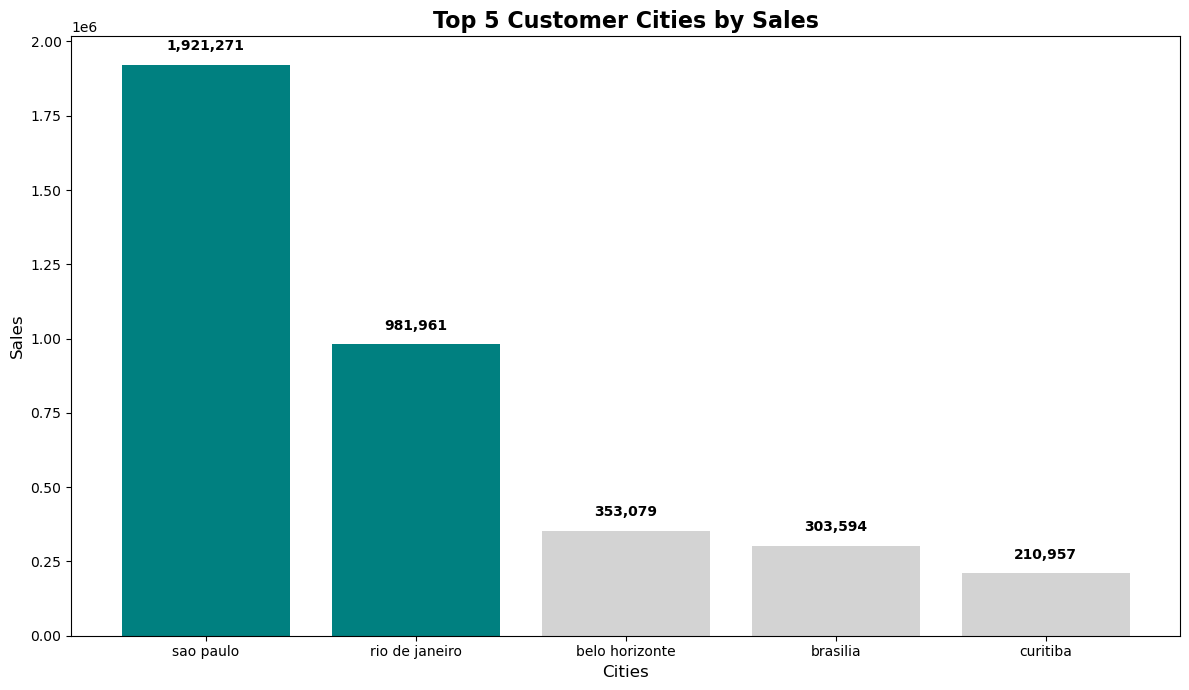

In [7]:
# Calculate and sort the top 5 geographic regions by customer sales
top_geo_customer = df.groupby('customer_city')['price'].sum().sort_values(ascending=False).head(5)

# Plot with enhancements
plt.figure(figsize=(12, 7))
colors = ['teal' if i < 2 else 'lightgray' for i in range(len(top_geo_customer))]  # Highlight top 2 bars
bars = plt.bar(
    top_geo_customer.index, 
    top_geo_customer.values, 
    color=colors
)

# Enhancing titles and labels
plt.title("Top 5 Customer Cities by Sales", fontsize=16, weight='bold')
plt.xlabel("Cities", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding annotations outside the bars
for bar in bars:
    value = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        value + (top_geo_customer.max() * 0.02),  
        f"{value:,.0f}",  
        ha='center',  
        va='bottom',  
        fontsize=10,
        color='black',
        weight='bold'
    )

# Adjusting layout
plt.tight_layout()

# Display the plot
plt.show()

#### Top 10 Sellers by Sales

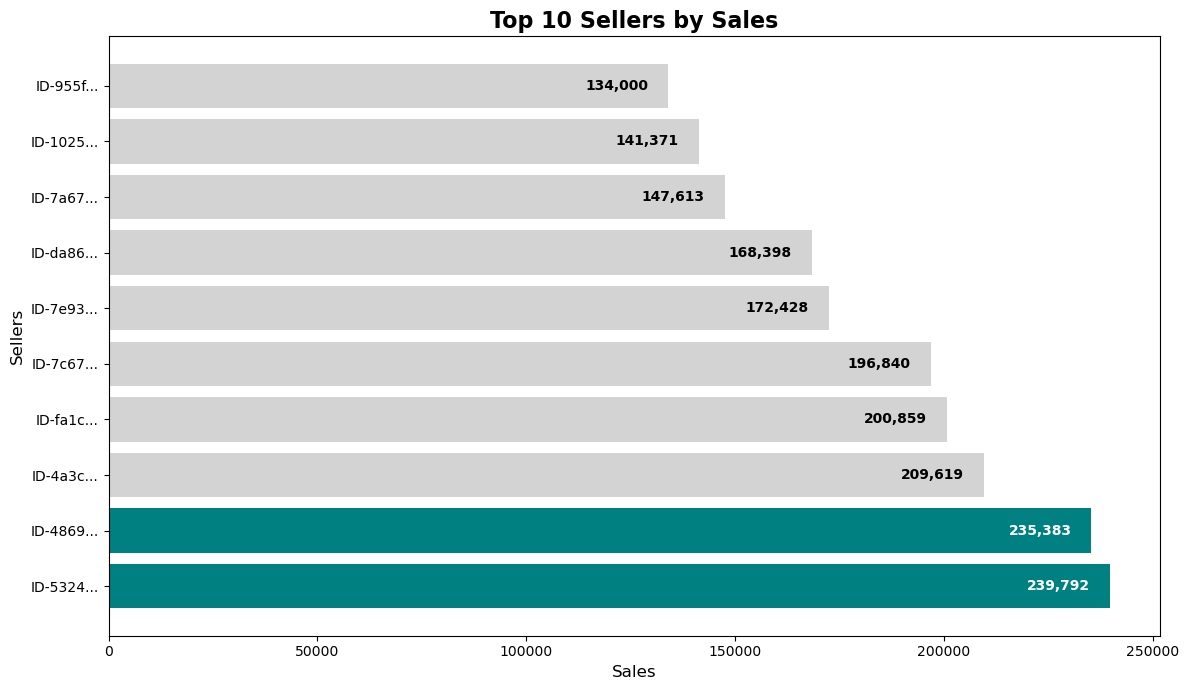

In [8]:
# Calculate and sort the top 10 sellers by sales
top_sellers = df.groupby('seller_id')['price'].sum().sort_values(ascending=False).head(10)

# Create a shortened version of seller IDs for display
short_seller_ids = [f"ID-{str(seller)[:4]}..." for seller in top_sellers.index]

# Plot with enhancements
plt.figure(figsize=(12, 7))
colors = ['lightgray' if i > 1 else 'teal' for i in range(len(top_sellers))]
bars = plt.barh(short_seller_ids, top_sellers.values, color=colors)

# Enhancing titles and labels
plt.title("Top 10 Sellers by Sales", fontsize=16, weight='bold')
plt.xlabel("Sales", fontsize=12)
plt.ylabel("Sellers", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding annotations inside or beside the bars
for bar, value, color in zip(bars, top_sellers.values, colors):
    text_color = 'black' if color == 'lightgray' else 'white'
    plt.text(
        value - (top_sellers.max() * 0.02),
        bar.get_y() + bar.get_height() / 2,
        f"{value:,.0f}",
        va='center',
        ha='right',
        fontsize=10,
        color=text_color,
        weight='bold'
    )

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

#### RFM Analysis

In [9]:
#Calcuate Recency
df['Recency'] = (df['order_purchase_timestamp'].max() - df['order_purchase_timestamp']).dt.days

In [10]:
#Create FRM table
df_rfm = df.groupby('customer_unique_id').agg({'Recency' : 'min',
                          'order_purchase_timestamp' : pd.Series.nunique,
                          'price' : 'sum'})
#Rename columns
df_rfm.rename(columns={'Recency':'Recency', 'order_purchase_timestamp':'Frequency', 'price':'Monetary'}, inplace=True)

df_rfm

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
0000f46a3911fa3c0805444483337064,536,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99
0004aac84e0df4da2b147fca70cf8255,287,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,261,1,64.89
ffff371b4d645b6ecea244b27531430a,567,1,89.90


In [11]:
# Create RFM scores based on the quantiles of the distribution for each column

# Date from customer's last purchase. The most recent date gets 4 and the oldest gets 1
# qcut = quantile cut
df_rfm['recency_score'] = pd.qcut(df_rfm['Recency'], 4, labels=[4,3,2,1])

# Total number of days with purchase. The lowest frequency gets 1 and the highest gets 4
df_rfm['frequency_score'] = pd.qcut(df_rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])

# Total spend of each customer. The lowest amount gets 1 and the highest gets 4
df_rfm['monetary_score'] = pd.qcut(df_rfm['Monetary'], 4, labels=[1,2,3,4])

df_rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4,1,3
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3,1,1
0000f46a3911fa3c0805444483337064,536,1,69.00,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2,1,1
0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2,1,4


In [12]:
df_rfm['RFM_Segment'] = df_rfm['recency_score'].astype(str)+df_rfm['frequency_score'].astype(str)+df_rfm['monetary_score'].astype(str)

df_rfm['RFM_Score'] = df_rfm[['recency_score','frequency_score','monetary_score']].sum(axis=1)

df_rfm

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4,1,3,413,8
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3,1,1,311,5
0000f46a3911fa3c0805444483337064,536,1,69.00,1,1,2,112,4
0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2,1,1,211,4
0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2,1,4,214,7
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,1,1570.00,1,4,4,144,9
fffea47cd6d3cc0a88bd621562a9d061,261,1,64.89,2,4,2,242,8
ffff371b4d645b6ecea244b27531430a,567,1,89.90,1,4,2,142,7


In [13]:
# Use regex and dictionaries values to categorize numbers from customers
segt_map = {
    r'[3-4][3-4]4': 'VIP',
    r'[2-3-4][1-2-3-4]4': 'Top Recent',
    r'1[1-2-3-4]4': 'Top at Risk ',

    
    
    r'[3-4][3-4]3': 'High Promising',
    r'[2-3-4][1-2]3': 'High New',
    r'2[3-4]3': 'High Loyal',

    
    
    r'[3-4][3-4]2': 'Medium Potential',
    r'[2-3-4][1-2]2': 'Medium New',
    r'2[3-4]2': 'Medium Loyal',

    
    
    r'4[1-2-3-4]1': 'Low New',
    r'[2-3][1-2-3-4]1': 'Low Loyal',
    
    r'1[1-2-3-4][1-2-3]': 'Need Activation'
}

df_rfm['Segment_labels'] = df_rfm['RFM_Segment']
df_rfm['Segment_labels'] = df_rfm['Segment_labels'].replace(segt_map, regex=True)

In [20]:
#Calculate Customers per Segments and all Stats per Segment
segements_grouped = df_rfm.groupby(["Segment_labels"]).agg({'Monetary': np.sum,
                                   "customer_unique_id": pd.Series.nunique,
                                    "Recency": np.mean,                     
                                     "Frequency": np.mean,
                                                        }).reset_index()

segements_grouped["Monetary%"] = segements_grouped["Monetary"]/segements_grouped["Monetary"].sum()*100
segements_grouped["Count%"] = segements_grouped["customer_unique_id"]/segements_grouped["customer_unique_id"].sum()*100

segements_grouped.rename(columns={'Monetary':'TotalMonetary','customer_unique_id':'TotalCustomers',
                                 'Recency':'MeanRecency','Frequency':'MeanFrequency',
                                 "Count%":"Customers%"},inplace= True)


segements_grouped = segements_grouped.sort_values(by=['Monetary%'], ascending=False)
segements_grouped

,Segment_labels,TotalMonetary,TotalCustomers,MeanRecency,MeanFrequency,Monetary%,Customers%
9,Top Recent,4084736.63,10971,196.343998,1.036460,29.973844,11.914510
11,VIP,2279923.58,6042,111.350877,1.173784,16.730105,6.561614
10,Top at Risk,2231134.97,5725,451.497293,1.050655,16.372094,6.217352
8,Need Activation,1216477.86,17160,449.853205,1.013636,8.926528,18.635766
1,High New,1080364.84,8878,163.402005,1.000000,7.927730,9.641511
2,High Promising,719471.75,5907,110.022685,1.060437,5.279492,6.415004
6,Medium New,586124.06,8739,167.463440,1.000000,4.300985,9.490557
7,Medium Potential,366367.22,5448,109.415565,1.029919,2.688407,5.916530
0,High Loyal,341547.70,2821,276.583127,1.056009,2.506281,3.063607
3,Low Loyal,339874.76,11436,219.419902,1.003235,2.494005,12.419500


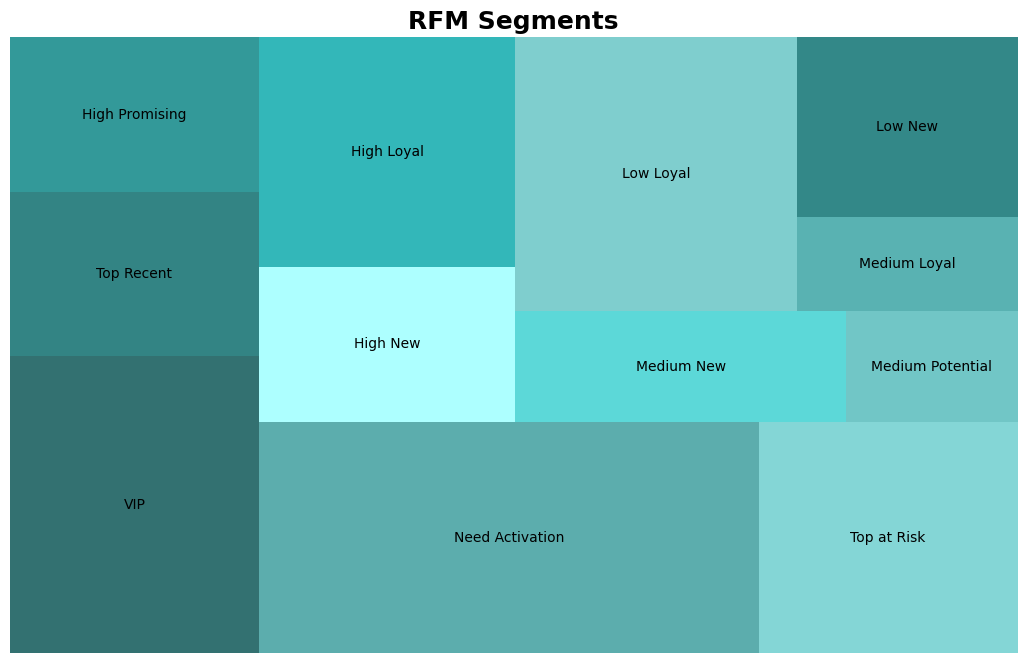

In [21]:
# Plot Segments in a Treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 8)


# use squarify to plot treemap
sq.plot(sizes=segements_grouped["Customers%"], 
                      label=['VIP', 
                            "Top Recent", 
                            'High Promising', 
                            'Need Activation', 
                            'Top at Risk', 
                            'High New', 
                            'High Loyal',
                            'Medium New',
                            'Medium Potential',
                            'Low Loyal',
                            'Medium Loyal',
                            'Low New'], 
                            alpha=0.8, 
                            color=["#004D4D", "#006666", "#008080", "#339999", "#66CCCC", 
         "#99FFFF", "#00A5A8", "#33CFCF", "#4DB8B8", "#5FC2C2", 
         "#2F9F9F", "#006B6B"])
plt.title("RFM Segments", fontsize=18, fontweight="bold")
plt.axis('off')
plt.show()

#### Pareto Analysis

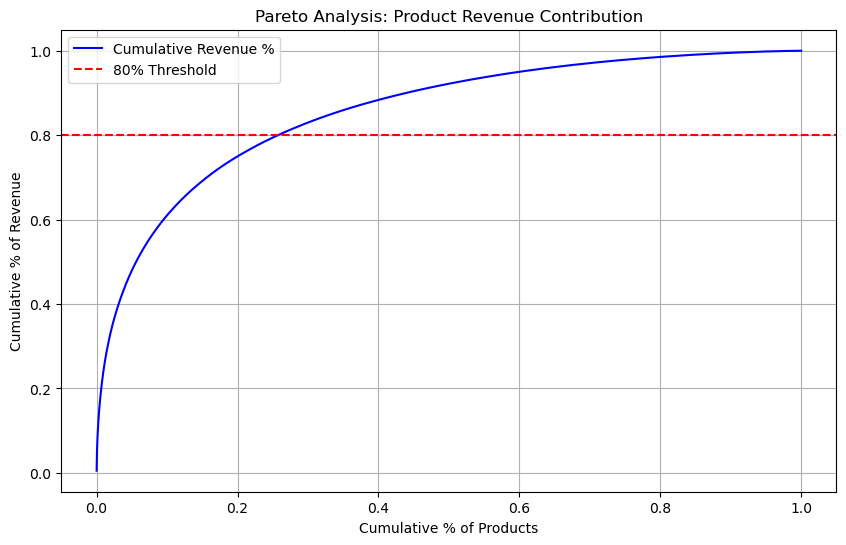

25.74% of products contribute to 80% of revenue.


In [22]:
# Group by product to calculate total revenue per product
product_data = df.groupby('product_id').agg({
    'price': 'sum'
}).reset_index()

# Sort products by revenue
product_data = product_data.sort_values('price', ascending=False).reset_index(drop=True)

# Calculate cumulative revenue and percentage
product_data['CumulativeRevenue'] = product_data['price'].cumsum()
product_data['CumulativeRevenuePct'] = product_data['CumulativeRevenue'] / product_data['price'].sum()
product_data['ProductPct'] = (product_data.index + 1) / len(product_data)


plt.figure(figsize=(10, 6))
plt.plot(product_data['ProductPct'], product_data['CumulativeRevenuePct'], label='Cumulative Revenue %', color='blue')
plt.axhline(y=0.8, color='red', linestyle='--', label='80% Threshold')
plt.title('Pareto Analysis: Product Revenue Contribution')
plt.xlabel('Cumulative % of Products')
plt.ylabel('Cumulative % of Revenue')
plt.legend()
plt.grid()
plt.show()

# Identify the percentage of products contributing to 80% of revenue
pareto_cutoff = product_data[product_data['CumulativeRevenuePct'] <= 0.8].shape[0] / len(product_data)
pareto_cutoff_percentage = pareto_cutoff * 100
print(f"{pareto_cutoff_percentage:.2f}% of products contribute to 80% of revenue.")